In [1]:
# ===============================================================
# 🔰 Step 1 — Import Libraries
# ===============================================================
import numpy as np
import pandas as pd
import os, time
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc


In [2]:
# ===============================================================
# 🔰 Step 2 — Device Setup & Data Preparation
# ===============================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ✅ Dataset path (change if needed)
DATA_DIR = "/kaggle/input/dataset-of-plant-parasitic-nematodes/Microscopic Image Dataset of Plant-Parasitic Nematodes"

# ✅ Image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# ✅ Load dataset using ImageFolder
dataset = datasets.ImageFolder(DATA_DIR, transform=transform)

# ✅ Split 70:30 (Train:Test)
test_ratio = 0.3
test_size = int(test_ratio * len(dataset))
train_size = len(dataset) - test_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
print(f"Train: {len(train_dataset)}, Test: {len(test_dataset)}")

# ✅ Split 10% of Train as Validation
val_ratio = 0.1
val_size = int(val_ratio * len(train_dataset))
train_size_final = len(train_dataset) - val_size
train_dataset, val_dataset = random_split(train_dataset, [train_size_final, val_size])
print(f"Train: {len(train_dataset)}, Validation: {len(val_dataset)}, Test: {len(test_dataset)}")

# ✅ Dataloader setup
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Using device: cuda
Train: 712, Test: 304
Train: 641, Validation: 71, Test: 304


In [3]:
# ===============================================================
# 🔰 Step 3 — Model: GoogLeNet (Updated for Torchvision ≥ 0.13)
# ===============================================================
from torchvision.models import googlenet, GoogLeNet_Weights

# ✅ Use modern weights API
weights = GoogLeNet_Weights.DEFAULT
model = googlenet(weights=weights)  # aux_logits=True by default

# ⚙️ Disable auxiliary classifier during training if not needed
model.aux_logits = False

# ✅ Replace final fully connected layer
num_classes = len(dataset.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)

# ✅ Move model to device
model = model.to(device)

# ✅ Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 165MB/s]


In [4]:
# ===============================================================
# 🔰 Step 4 — Train & Evaluate Functions
# ===============================================================
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in tqdm(loader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return running_loss / total, correct / total


def evaluate(model, loader, criterion):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    all_preds, all_labels, all_probs = [], [], []
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Evaluating", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            probs = torch.softmax(outputs, dim=1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    return running_loss / total, correct / total, np.array(all_preds), np.array(all_labels), np.array(all_probs)


In [5]:
# ===============================================================
# 🔰 Step 5 — Training Loop
# ===============================================================
num_epochs = 50
train_losses, val_losses = [], []
train_accs, val_accs = [], []

best_val_acc = 0.0
start_time = time.time()
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc, _, _, _ = evaluate(model, val_loader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_googlenet_model.pth")

end_time = time.time()
train_time = end_time - start_time
print(f"\n✅ Total training time: {train_time:.2f} sec")



Epoch 1/50


Train Loss: 2.1976, Acc: 0.2418 | Val Loss: 2.0002, Acc: 0.3239

Epoch 2/50


Train Loss: 1.6033, Acc: 0.6131 | Val Loss: 1.6862, Acc: 0.4366

Epoch 3/50


Train Loss: 1.1786, Acc: 0.7535 | Val Loss: 1.4584, Acc: 0.5211

Epoch 4/50


Train Loss: 0.8295, Acc: 0.8736 | Val Loss: 1.3115, Acc: 0.6620

Epoch 5/50


Train Loss: 0.5649, Acc: 0.9345 | Val Loss: 1.1620, Acc: 0.6901

Epoch 6/50


Train Loss: 0.3833, Acc: 0.9626 | Val Loss: 1.0864, Acc: 0.7042

Epoch 7/50


Train Loss: 0.2672, Acc: 0.9797 | Val Loss: 0.9965, Acc: 0.7183

Epoch 8/50


Train Loss: 0.1911, Acc: 0.9844 | Val Loss: 0.9685, Acc: 0.7042

Epoch 9/50


Train Loss: 0.1440, Acc: 0.9844 | Val Loss: 0.9398, Acc: 0.7606

Epoch 10/50


Train Loss: 0.1138, Acc: 0.9860 | Val Loss: 0.9382, Acc: 0.7324

Epoch 11/50


Train Loss: 0.0933, Acc: 0.9875 | Val Loss: 0.9177, Acc: 0.7183

Epoch 12/50


Train Loss: 0.0834, Acc: 0.9891 | Val Loss: 0.8603, Acc: 0.7042

Epoch 13/50


Train Loss: 0.0738, Acc: 0.9938 | Val Loss: 0.8645, Acc: 0.7183

Epoch 14/50


Train Loss: 0.0605, Acc: 0.9953 | Val Loss: 0.9613, Acc: 0.7465

Epoch 15/50


Train Loss: 0.0563, Acc: 0.9969 | Val Loss: 0.9032, Acc: 0.7465

Epoch 16/50


Train Loss: 0.0469, Acc: 0.9953 | Val Loss: 0.8881, Acc: 0.7465

Epoch 17/50


Train Loss: 0.0456, Acc: 0.9969 | Val Loss: 0.8924, Acc: 0.7746

Epoch 18/50


Train Loss: 0.0391, Acc: 0.9984 | Val Loss: 0.8634, Acc: 0.7606

Epoch 19/50


Train Loss: 0.0401, Acc: 0.9984 | Val Loss: 0.8630, Acc: 0.7887

Epoch 20/50


Train Loss: 0.0350, Acc: 0.9984 | Val Loss: 0.8766, Acc: 0.7606

Epoch 21/50


Train Loss: 0.0295, Acc: 0.9984 | Val Loss: 0.8020, Acc: 0.7887

Epoch 22/50


Train Loss: 0.0264, Acc: 0.9984 | Val Loss: 0.7617, Acc: 0.7887

Epoch 23/50


Train Loss: 0.0262, Acc: 0.9984 | Val Loss: 0.7763, Acc: 0.7887

Epoch 24/50


Train Loss: 0.0222, Acc: 1.0000 | Val Loss: 0.7417, Acc: 0.7324

Epoch 25/50


Train Loss: 0.0242, Acc: 0.9984 | Val Loss: 0.9035, Acc: 0.7324

Epoch 26/50


Train Loss: 0.0223, Acc: 0.9984 | Val Loss: 0.8083, Acc: 0.7465

Epoch 27/50


Train Loss: 0.0204, Acc: 0.9984 | Val Loss: 0.8609, Acc: 0.7183

Epoch 28/50


Train Loss: 0.0175, Acc: 1.0000 | Val Loss: 0.7917, Acc: 0.7042

Epoch 29/50


Train Loss: 0.0187, Acc: 0.9984 | Val Loss: 0.7688, Acc: 0.7324

Epoch 30/50


Train Loss: 0.0237, Acc: 0.9984 | Val Loss: 0.7957, Acc: 0.7042

Epoch 31/50


Train Loss: 0.0154, Acc: 0.9984 | Val Loss: 0.7262, Acc: 0.7887

Epoch 32/50


Train Loss: 0.0187, Acc: 0.9984 | Val Loss: 0.8196, Acc: 0.7324

Epoch 33/50


Train Loss: 0.0171, Acc: 0.9984 | Val Loss: 0.8227, Acc: 0.7606

Epoch 34/50


Train Loss: 0.0166, Acc: 0.9984 | Val Loss: 0.7393, Acc: 0.7887

Epoch 35/50


Train Loss: 0.0120, Acc: 0.9984 | Val Loss: 0.7710, Acc: 0.7746

Epoch 36/50


Train Loss: 0.0168, Acc: 0.9984 | Val Loss: 0.8186, Acc: 0.7324

Epoch 37/50


Train Loss: 0.0166, Acc: 0.9984 | Val Loss: 0.7732, Acc: 0.7324

Epoch 38/50


Train Loss: 0.0116, Acc: 1.0000 | Val Loss: 0.7355, Acc: 0.7887

Epoch 39/50


Train Loss: 0.0156, Acc: 0.9984 | Val Loss: 0.8572, Acc: 0.7465

Epoch 40/50


Train Loss: 0.0142, Acc: 0.9984 | Val Loss: 0.8718, Acc: 0.7606

Epoch 41/50


Train Loss: 0.0142, Acc: 0.9984 | Val Loss: 0.7712, Acc: 0.7606

Epoch 42/50


Train Loss: 0.0127, Acc: 0.9984 | Val Loss: 0.7777, Acc: 0.7465

Epoch 43/50


Train Loss: 0.0148, Acc: 0.9984 | Val Loss: 0.8660, Acc: 0.7465

Epoch 44/50


Train Loss: 0.0141, Acc: 0.9984 | Val Loss: 0.7917, Acc: 0.7465

Epoch 45/50


Train Loss: 0.0127, Acc: 0.9984 | Val Loss: 0.7539, Acc: 0.7746

Epoch 46/50


Train Loss: 0.0171, Acc: 0.9984 | Val Loss: 0.7507, Acc: 0.7465

Epoch 47/50


Train Loss: 0.0158, Acc: 0.9984 | Val Loss: 0.7679, Acc: 0.7746

Epoch 48/50


Train Loss: 0.0116, Acc: 0.9984 | Val Loss: 0.7432, Acc: 0.8028

Epoch 49/50


Train Loss: 0.0101, Acc: 0.9984 | Val Loss: 0.7911, Acc: 0.7183

Epoch 50/50


Train Loss: 0.0119, Acc: 0.9984 | Val Loss: 0.7965, Acc: 0.8028

✅ Total training time: 731.67 sec


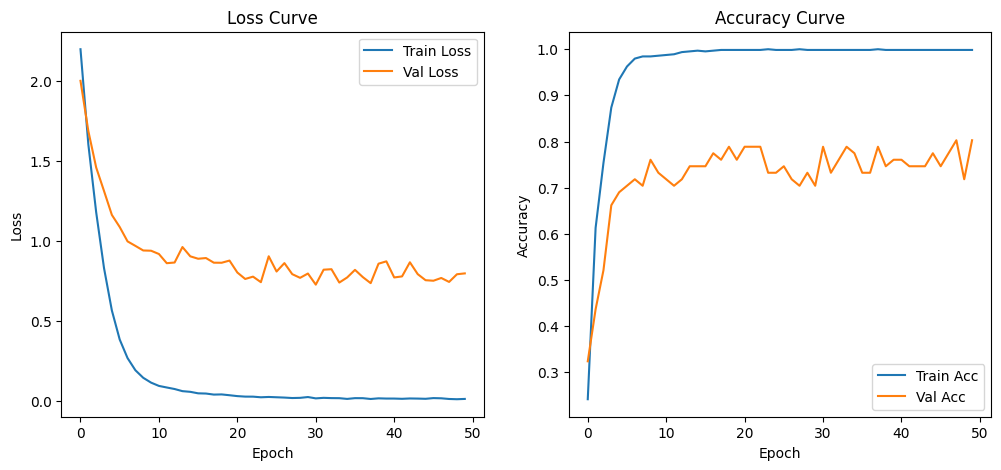

In [6]:
# ===============================================================
# 🔰 Step 6 — Plot Loss & Accuracy Curves
# ===============================================================
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [7]:
# ===============================================================
# 🔰 Step 7 — Test Evaluation
# ===============================================================
model.load_state_dict(torch.load("best_googlenet_model.pth"))
test_start = time.time()
test_loss, test_acc, all_preds, all_labels, all_probs = evaluate(model, test_loader, criterion)
test_end = time.time()
test_time = test_end - test_start
print(f"\n✅ Test Accuracy: {test_acc*100:.2f}%")
print(f"✅ Test time: {test_time:.2f} sec")



✅ Test Accuracy: 75.99%
✅ Test time: 7.28 sec



Classification Report:
                       precision    recall  f1-score   support

  Genus Criconemoides     1.0000    0.7368    0.8485        38
Genus Helicotylenchus     0.8974    0.8537    0.8750        41
Genus Hemicycliophora     0.0000    0.0000    0.0000         1
 Genus Hirschmaniella     0.6735    0.7857    0.7253        42
    Genus Hoplolaimus     0.6032    0.9048    0.7238        42
    Genus Meloidogyne     0.8519    0.6571    0.7419        70
   Genus Pratylenchus     0.6667    0.6000    0.6316        30
     Genus Radopholus     0.8571    0.7500    0.8000         8
    Genus Trichodorus     0.8824    0.8824    0.8824        17
      Genus Xiphinema     0.6000    0.8000    0.6857        15

             accuracy                         0.7599       304
            macro avg     0.7032    0.6970    0.6914       304
         weighted avg     0.7859    0.7599    0.7617       304



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


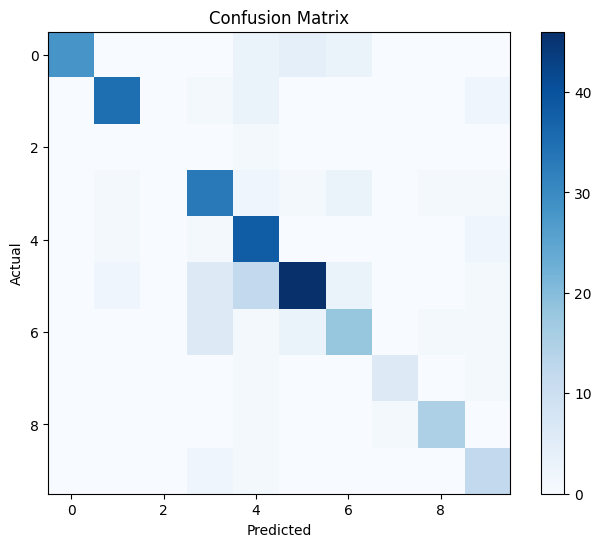


Per-class Accuracy:
Genus Criconemoides: 73.68%
Genus Helicotylenchus: 85.37%
Genus Hemicycliophora: 0.00%
Genus Hirschmaniella: 78.57%
Genus Hoplolaimus: 90.48%
Genus Meloidogyne: 65.71%
Genus Pratylenchus: 60.00%
Genus Radopholus: 75.00%
Genus Trichodorus: 88.24%
Genus Xiphinema: 80.00%


In [8]:
# ===============================================================
# 🔰 Step 8 — Classification Report & Confusion Matrix
# ===============================================================
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

unique_labels = sorted(list(set(all_labels)))
target_names = [dataset.classes[i] for i in unique_labels]

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, labels=unique_labels, target_names=target_names, digits=4))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.colorbar()
plt.show()

per_class_acc = cm.diagonal() / cm.sum(axis=1)
print("\nPer-class Accuracy:")
for i, label_idx in enumerate(unique_labels):
    cls_name = dataset.classes[label_idx]
    print(f"{cls_name}: {per_class_acc[i]*100:.2f}%")


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


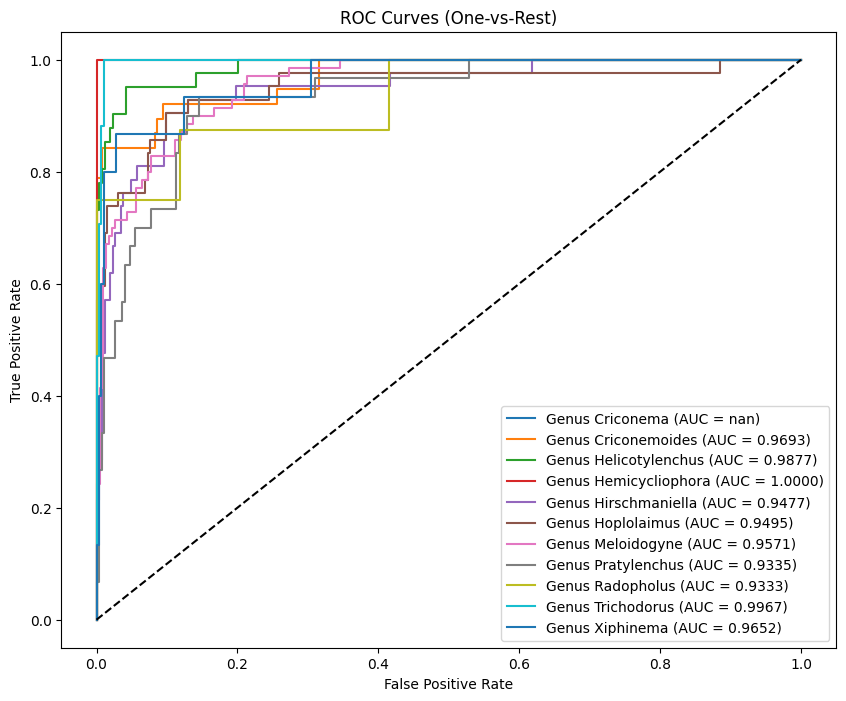

In [9]:
# ===============================================================
# 🔰 Step 9 — ROC-AUC per class
# ===============================================================
import numpy as np
from sklearn.metrics import roc_curve, auc

# Ensure numpy arrays
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

plt.figure(figsize=(10,8))
for i, cls in enumerate(dataset.classes):
    # ✅ Convert to binary (1 vs rest)
    binary_labels = (all_labels == i).astype(int)
    
    # ✅ Calculate ROC curve for this class
    fpr, tpr, _ = roc_curve(binary_labels, all_probs[:, i])
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, label=f'{cls} (AUC = {roc_auc:.4f})')

plt.plot([0,1],[0,1],'k--')
plt.title("ROC Curves (One-vs-Rest)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


In [10]:
# ===============================================================
# 🔰 Step 10 — Full Metrics Evaluation
# ===============================================================
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

all_labels = np.array(all_labels)
all_preds  = np.array(all_preds)

accuracy  = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
recall    = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
f1        = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

print("✅ Full Model Metrics on Test Set:")
print(f"Accuracy : {accuracy*100:.2f}%")
print(f"Precision: {precision*100:.2f}%")
print(f"Recall   : {recall*100:.2f}%")
print(f"F1-Score : {f1*100:.2f}%")


✅ Full Model Metrics on Test Set:
Accuracy : 75.99%
Precision: 78.59%
Recall   : 75.99%
F1-Score : 76.17%
